In [10]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# Dataset Definition
# --------------------------
class BatteryDataset(Dataset):
    def __init__(self, pkl_paths):
        self.paths = pkl_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path,weights_only=False)
        x = torch.tensor(data[0], dtype=torch.float32)
        label_raw = float(data[1]['label'])  # 여기 중요
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)

        return x, y

In [11]:

# --------------------------
# LSTM Model
# --------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝
        return out.squeeze(1)


In [ ]:

# --------------------------
# Prepare Data
# --------------------------
train_paths = glob('./dataset/battery_brand2/train/*.pkl')
test_paths = glob('./dataset/battery_brand2/test/*.pkl')

# 클래스별 비율
normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths) 
abnormal_count = sum(int(torch.load(p)[1]['label']) == 10 for p in train_paths) 
pos_weight = torch.tensor([normal_count / abnormal_count])

train_dataset = BatteryDataset(train_paths)
test_dataset = BatteryDataset(test_paths)
train_loader = DataLoader(train_dataset, batch_size=512*4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512*4,  pin_memory=True)


/tmp/ipykernel_1999187/983093049.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
/tmp/ipyker

In [100]:

# --------------------------
# Training Loop
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 50
loss_history = []

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [96]:
X_batch, y_batch = next(iter(train_loader))
print("y 라벨 샘플:", y_batch[:10])
print("y 데이터 타입:", y_batch.dtype)
print("y 고유 값들:", y_batch.unique())

y 라벨 샘플: tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 1.])
y 데이터 타입: torch.float32
y 고유 값들: tensor([0., 1.])


In [101]:
from sklearn.metrics import accuracy_score

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        # accuracy 계산을 위한 예측 결과 수집
        preds = torch.sigmoid(logits) > 0.5
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_loss_history.append(avg_loss)
    train_acc_history.append(train_acc)

    scheduler.step(avg_loss)

    model.eval()
    test_loss = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            logits_test = model(X_test)
            loss_test = criterion(logits_test, y_test)
            test_loss += loss_test.item() * X_test.size(0)

            preds_test = (torch.sigmoid(logits_test) > 0.5).float()
            test_preds.extend(preds_test.cpu().numpy())
            test_labels.extend(y_test.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = accuracy_score(test_labels, test_preds)
    test_loss_history.append(avg_test_loss)
    test_acc_history.append(test_acc)

    print(f"[Epoch {epoch+1:02d}] Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} || Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.4f}")


  2%|▏         | 1/50 [01:09<56:55, 69.70s/it]

[Epoch 01] Train Loss: 0.4167 | Train Acc: 0.7651 || Test Loss: 0.3357 | Test Acc: 0.8224


  4%|▍         | 2/50 [02:19<55:45, 69.71s/it]

[Epoch 02] Train Loss: 0.3155 | Train Acc: 0.8340 || Test Loss: 0.2799 | Test Acc: 0.8623


  6%|▌         | 3/50 [03:30<55:13, 70.50s/it]

[Epoch 03] Train Loss: 0.3102 | Train Acc: 0.8395 || Test Loss: 0.2927 | Test Acc: 0.8346


  8%|▊         | 4/50 [04:42<54:22, 70.92s/it]

[Epoch 04] Train Loss: 0.2941 | Train Acc: 0.8432 || Test Loss: 0.2640 | Test Acc: 0.8793


 10%|█         | 5/50 [05:52<52:57, 70.60s/it]

[Epoch 05] Train Loss: 0.2635 | Train Acc: 0.8714 || Test Loss: 0.2368 | Test Acc: 0.9002


 12%|█▏        | 6/50 [07:01<51:29, 70.21s/it]

[Epoch 06] Train Loss: 0.2502 | Train Acc: 0.8744 || Test Loss: 0.2497 | Test Acc: 0.8819


 12%|█▏        | 6/50 [08:04<59:15, 80.82s/it]


KeyboardInterrupt: 

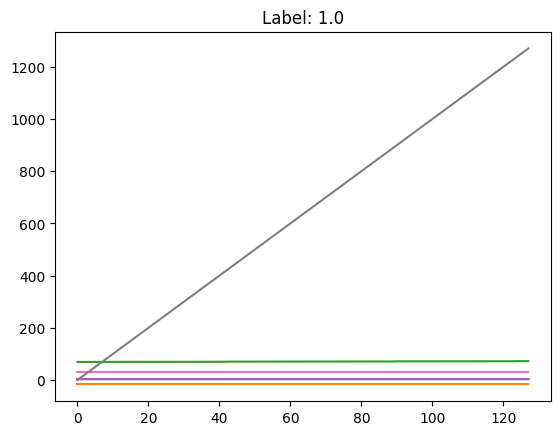

In [17]:
import matplotlib.pyplot as plt
sample_x, sample_y = next(iter(train_loader))
plt.plot(sample_x[0].cpu().numpy())  # 시계열 128x8 중 첫 샘플
plt.title(f"Label: {sample_y[0].item()}")
plt.show()


In [20]:
# --------------------------
# Save Model & Hyperparameters
# --------------------------
os.makedirs('./saved_models', exist_ok=True)
torch.save(model.state_dict(), './saved_models/lstm_brand2.pt')
torch.save({
    'input_dim': 8,
    'hidden_dim': 64,
    'num_layers': 2,
    'pos_weight': pos_weight.item(),
    'lr': 1e-2,
    'batch_size': 512*4,
    'epochs': num_epochs,
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(), 
}, './saved_models/lstm_brand2_hparams.pt')

In [27]:
from sklearn.preprocessing import StandardScaler

class BatteryDataset(Dataset):
    def __init__(self, pkl_paths):
        self.paths = pkl_paths
        self.scaler = StandardScaler()

        # 모든 데이터를 flatten 후 fit (학습셋에 대해서만)
        all_data = []
        for path in self.paths:
            x = torch.load(path, weights_only=False)[0]
            all_data.append(x)
        all_data = np.concatenate(all_data, axis=0)
        self.scaler.fit(all_data)
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y

In [28]:
class BatteryTestDataset(Dataset):
    def __init__(self, pkl_paths, scaler):
        self.paths = pkl_paths
        self.scaler = scaler

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [29]:
# --------------------------
# Prepare Data
# --------------------------
train_paths = glob('./dataset/battery_brand2/train/*.pkl')
test_paths = glob('./dataset/battery_brand2/test/*.pkl')

# 클래스별 비율
normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
abnormal_count = sum(int(torch.load(p)[1]['label']) == 10 for p in train_paths)
pos_weight = torch.tensor([normal_count / abnormal_count])

train_dataset = BatteryDataset(train_paths)
test_dataset = BatteryTestDataset(test_paths,  scaler=train_dataset.scaler)
train_loader = DataLoader(train_dataset, batch_size=512*4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512*4,  pin_memory=True)

/tmp/ipykernel_1999187/3818507453.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
/tmp/ipyke

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 1000
loss_history = []

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [35]:
from sklearn.metrics import accuracy_score

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        # accuracy 계산을 위한 예측 결과 수집
        preds = torch.sigmoid(logits) > 0.5
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    loss_history.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"[Epoch {epoch+1:02d}] Average Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")


  0%|          | 1/1000 [00:42<11:51:35, 42.74s/it]

[Epoch 01] Average Loss: 0.4077 | Train Accuracy: 0.7593


  0%|          | 2/1000 [01:25<11:55:02, 42.99s/it]

[Epoch 02] Average Loss: 0.3191 | Train Accuracy: 0.8239


  0%|          | 3/1000 [02:08<11:51:37, 42.83s/it]

[Epoch 03] Average Loss: 0.3307 | Train Accuracy: 0.8274


  0%|          | 4/1000 [02:51<11:52:36, 42.93s/it]

[Epoch 04] Average Loss: 0.2786 | Train Accuracy: 0.8648


  0%|          | 5/1000 [03:35<11:56:12, 43.19s/it]

[Epoch 05] Average Loss: 0.2625 | Train Accuracy: 0.8707


  1%|          | 6/1000 [04:19<12:01:30, 43.55s/it]

[Epoch 06] Average Loss: 0.2819 | Train Accuracy: 0.8512


  1%|          | 7/1000 [05:02<11:59:25, 43.47s/it]

[Epoch 07] Average Loss: 0.2519 | Train Accuracy: 0.8687


  1%|          | 8/1000 [05:45<11:57:00, 43.37s/it]

[Epoch 08] Average Loss: 0.2297 | Train Accuracy: 0.8858


  1%|          | 9/1000 [06:28<11:51:53, 43.10s/it]

[Epoch 09] Average Loss: 0.2052 | Train Accuracy: 0.9013


  1%|          | 10/1000 [07:12<11:53:36, 43.25s/it]

[Epoch 10] Average Loss: 0.1946 | Train Accuracy: 0.9056


  1%|          | 11/1000 [07:55<11:53:01, 43.26s/it]

[Epoch 11] Average Loss: 0.1836 | Train Accuracy: 0.9112


  1%|          | 12/1000 [08:37<11:48:33, 43.03s/it]

[Epoch 12] Average Loss: 0.1724 | Train Accuracy: 0.9172


  1%|▏         | 13/1000 [09:19<11:42:31, 42.71s/it]

[Epoch 13] Average Loss: 0.1745 | Train Accuracy: 0.9156


  1%|▏         | 14/1000 [10:01<11:39:10, 42.55s/it]

[Epoch 14] Average Loss: 0.1641 | Train Accuracy: 0.9206


  2%|▏         | 15/1000 [10:44<11:38:44, 42.56s/it]

[Epoch 15] Average Loss: 0.1743 | Train Accuracy: 0.9162


  2%|▏         | 16/1000 [11:27<11:37:21, 42.52s/it]

[Epoch 16] Average Loss: 0.1598 | Train Accuracy: 0.9227


  2%|▏         | 17/1000 [12:09<11:37:18, 42.56s/it]

[Epoch 17] Average Loss: 0.1743 | Train Accuracy: 0.9162


  2%|▏         | 18/1000 [12:52<11:37:12, 42.60s/it]

[Epoch 18] Average Loss: 0.1444 | Train Accuracy: 0.9302


  2%|▏         | 19/1000 [13:34<11:36:02, 42.57s/it]

[Epoch 19] Average Loss: 0.1545 | Train Accuracy: 0.9271


  2%|▏         | 20/1000 [14:18<11:39:36, 42.83s/it]

[Epoch 20] Average Loss: 0.1503 | Train Accuracy: 0.9280


  2%|▏         | 21/1000 [15:01<11:39:40, 42.88s/it]

[Epoch 21] Average Loss: 0.1383 | Train Accuracy: 0.9348


  2%|▏         | 22/1000 [15:44<11:38:03, 42.83s/it]

[Epoch 22] Average Loss: 0.1270 | Train Accuracy: 0.9394


  2%|▏         | 23/1000 [16:26<11:36:48, 42.79s/it]

[Epoch 23] Average Loss: 0.1339 | Train Accuracy: 0.9374


  2%|▏         | 24/1000 [17:09<11:34:59, 42.72s/it]

[Epoch 24] Average Loss: 0.1245 | Train Accuracy: 0.9418


  2%|▎         | 25/1000 [17:52<11:38:14, 42.97s/it]

[Epoch 25] Average Loss: 0.1122 | Train Accuracy: 0.9491


  3%|▎         | 26/1000 [18:35<11:35:55, 42.87s/it]

[Epoch 26] Average Loss: 0.1089 | Train Accuracy: 0.9511


  3%|▎         | 27/1000 [19:17<11:33:32, 42.77s/it]

[Epoch 27] Average Loss: 0.1076 | Train Accuracy: 0.9509


  3%|▎         | 28/1000 [20:00<11:32:23, 42.74s/it]

[Epoch 28] Average Loss: 0.0928 | Train Accuracy: 0.9584


  3%|▎         | 29/1000 [20:44<11:35:55, 43.00s/it]

[Epoch 29] Average Loss: 0.0921 | Train Accuracy: 0.9576


  3%|▎         | 30/1000 [21:28<11:42:03, 43.43s/it]

[Epoch 30] Average Loss: 0.0999 | Train Accuracy: 0.9572


  3%|▎         | 31/1000 [22:11<11:36:21, 43.12s/it]

[Epoch 31] Average Loss: 0.0779 | Train Accuracy: 0.9663


  3%|▎         | 32/1000 [22:53<11:32:30, 42.92s/it]

[Epoch 32] Average Loss: 0.0713 | Train Accuracy: 0.9685


  3%|▎         | 33/1000 [23:36<11:30:56, 42.87s/it]

[Epoch 33] Average Loss: 0.0688 | Train Accuracy: 0.9696


  3%|▎         | 34/1000 [24:18<11:28:08, 42.74s/it]

[Epoch 34] Average Loss: 0.0692 | Train Accuracy: 0.9700


  4%|▎         | 35/1000 [25:01<11:28:26, 42.81s/it]

[Epoch 35] Average Loss: 0.0635 | Train Accuracy: 0.9721


  4%|▎         | 36/1000 [25:44<11:27:12, 42.77s/it]

[Epoch 36] Average Loss: 0.0553 | Train Accuracy: 0.9762


  4%|▎         | 37/1000 [26:28<11:30:49, 43.04s/it]

[Epoch 37] Average Loss: 0.0612 | Train Accuracy: 0.9728


  4%|▍         | 38/1000 [27:11<11:31:52, 43.15s/it]

[Epoch 38] Average Loss: 0.0718 | Train Accuracy: 0.9688


  4%|▍         | 39/1000 [27:55<11:36:15, 43.47s/it]

[Epoch 39] Average Loss: 0.0590 | Train Accuracy: 0.9746


  4%|▍         | 40/1000 [28:40<11:40:28, 43.78s/it]

[Epoch 40] Average Loss: 0.0522 | Train Accuracy: 0.9774


  4%|▍         | 41/1000 [29:22<11:34:14, 43.43s/it]

[Epoch 41] Average Loss: 0.0562 | Train Accuracy: 0.9752


  4%|▍         | 42/1000 [30:05<11:30:35, 43.25s/it]

[Epoch 42] Average Loss: 0.0723 | Train Accuracy: 0.9686


  4%|▍         | 43/1000 [30:48<11:28:37, 43.17s/it]

[Epoch 43] Average Loss: 0.0587 | Train Accuracy: 0.9749


  4%|▍         | 44/1000 [31:31<11:25:04, 43.00s/it]

[Epoch 44] Average Loss: 0.0551 | Train Accuracy: 0.9759


  4%|▍         | 45/1000 [32:14<11:24:15, 42.99s/it]

[Epoch 45] Average Loss: 0.0387 | Train Accuracy: 0.9837


  5%|▍         | 46/1000 [32:56<11:22:22, 42.92s/it]

[Epoch 46] Average Loss: 0.0303 | Train Accuracy: 0.9870


  5%|▍         | 47/1000 [33:39<11:20:29, 42.84s/it]

[Epoch 47] Average Loss: 0.0315 | Train Accuracy: 0.9864


  5%|▍         | 48/1000 [34:21<11:16:14, 42.62s/it]

[Epoch 48] Average Loss: 0.0298 | Train Accuracy: 0.9874


  5%|▍         | 49/1000 [35:04<11:14:40, 42.57s/it]

[Epoch 49] Average Loss: 0.0279 | Train Accuracy: 0.9878


  5%|▌         | 50/1000 [35:46<11:14:59, 42.63s/it]

[Epoch 50] Average Loss: 0.0285 | Train Accuracy: 0.9875


  5%|▌         | 51/1000 [36:29<11:15:04, 42.68s/it]

[Epoch 51] Average Loss: 0.0276 | Train Accuracy: 0.9881


  5%|▌         | 52/1000 [37:13<11:17:15, 42.86s/it]

[Epoch 52] Average Loss: 0.0316 | Train Accuracy: 0.9859


  5%|▌         | 53/1000 [37:56<11:19:42, 43.06s/it]

[Epoch 53] Average Loss: 0.0274 | Train Accuracy: 0.9883


  5%|▌         | 54/1000 [38:40<11:22:41, 43.30s/it]

[Epoch 54] Average Loss: 0.0316 | Train Accuracy: 0.9866


  6%|▌         | 55/1000 [39:23<11:22:41, 43.35s/it]

[Epoch 55] Average Loss: 0.0269 | Train Accuracy: 0.9884


  6%|▌         | 56/1000 [40:06<11:19:06, 43.16s/it]

[Epoch 56] Average Loss: 0.0357 | Train Accuracy: 0.9844


  6%|▌         | 57/1000 [40:49<11:18:13, 43.15s/it]

[Epoch 57] Average Loss: 0.0255 | Train Accuracy: 0.9889


  6%|▌         | 58/1000 [41:32<11:15:44, 43.04s/it]

[Epoch 58] Average Loss: 0.0319 | Train Accuracy: 0.9864


  6%|▌         | 59/1000 [42:14<11:12:10, 42.86s/it]

[Epoch 59] Average Loss: 0.0267 | Train Accuracy: 0.9883


  6%|▌         | 59/1000 [42:35<11:19:18, 43.31s/it]


KeyboardInterrupt: 

In [90]:
train_acc

0.9882730371996012

In [58]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,
    roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


def evaluate_model(model, test_loader, device, threshold=0.8):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device).float()

            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).long()

            all_preds.extend(preds.cpu().numpy().astype(int))
            all_labels.extend(y.cpu().numpy().astype(int))
            all_probs.extend(probs.cpu().numpy())


    # 📊 스코어 계산
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"📊 Confusion Matrix:\n{cm}")


    # 📈 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # --- 추가: ROC Curve ---
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # --- 추가: PR Curve ---
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

    return all_preds, all_labels, all_probs

✅ Accuracy: 0.8539
✅ F1 Score: 0.8620
✅ Precision: 0.9379
✅ Recall: 0.7975
📊 Confusion Matrix:
[[29754  2262]
 [ 8678 34168]]


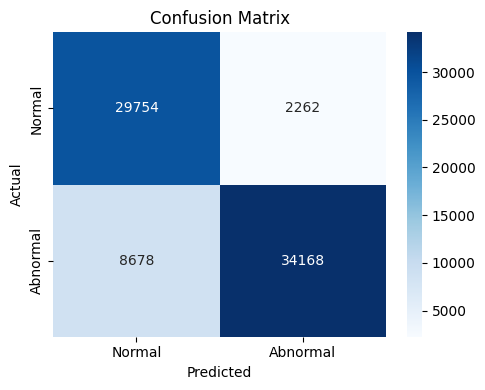

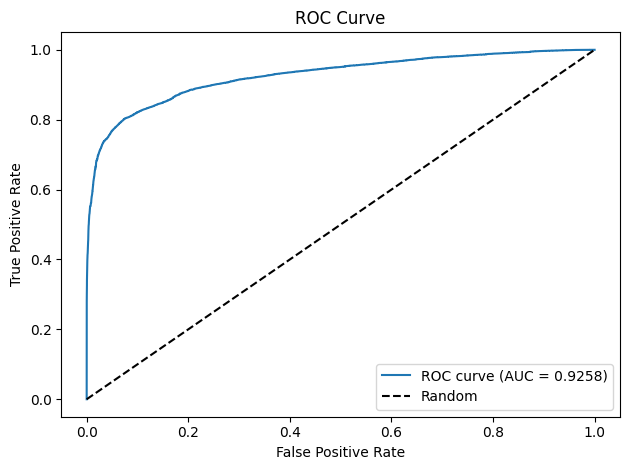

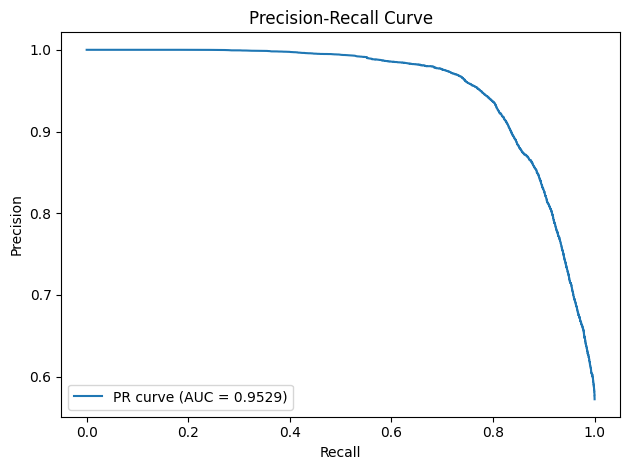

In [59]:
all_preds, all_labels, all_probs= evaluate_model(model, test_loader, device, threshold=0.85)

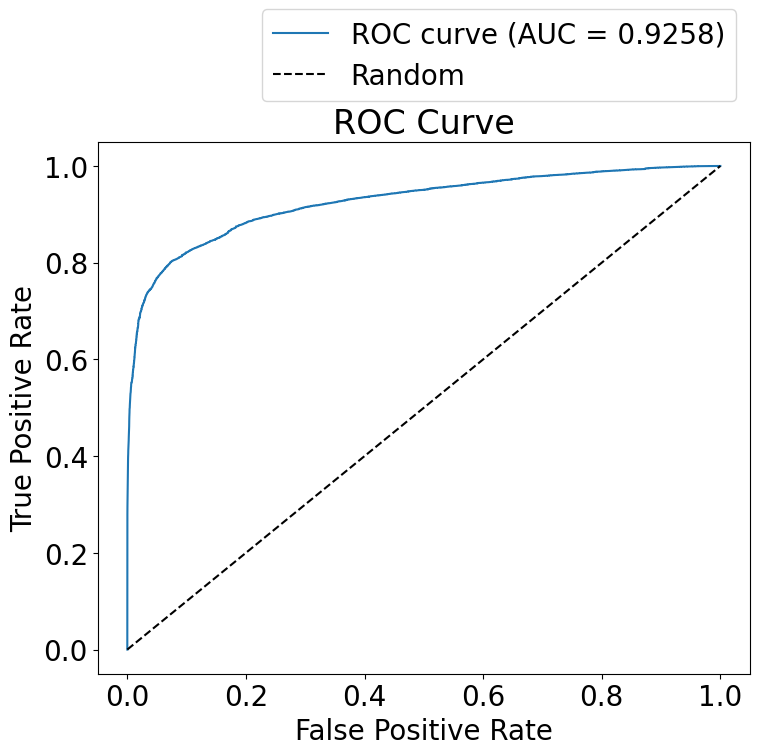

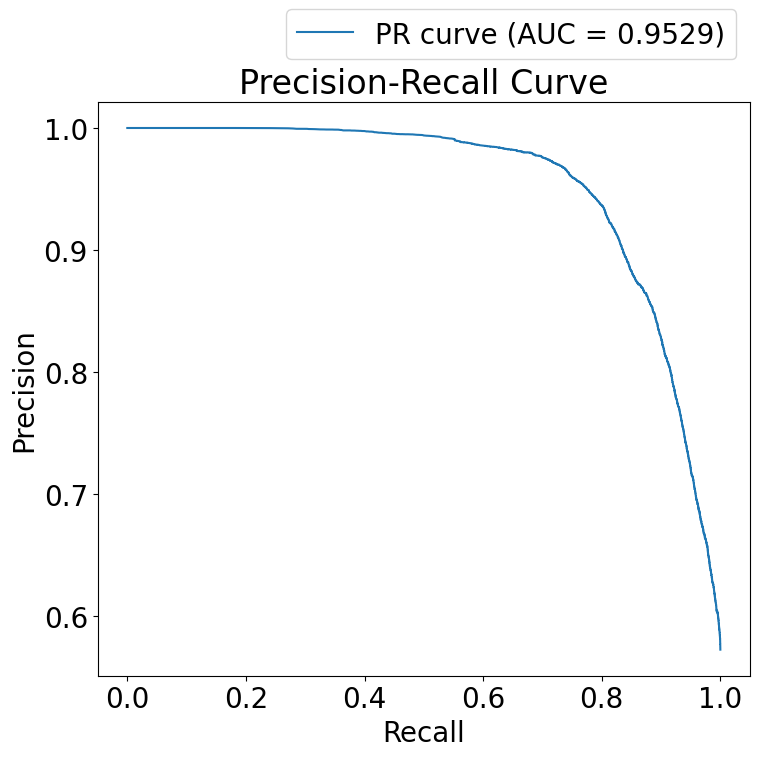

In [89]:
from matplotlib import rcParams as rc
    
plt.rc('font', size=20)
plt.rcParams["figure.figsize"] = (8,8)

# --- 추가: ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right",bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.show()
# --- 추가: PR Curve ---
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_vals, precision_vals)
plt.figure()
plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower right",bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.show()


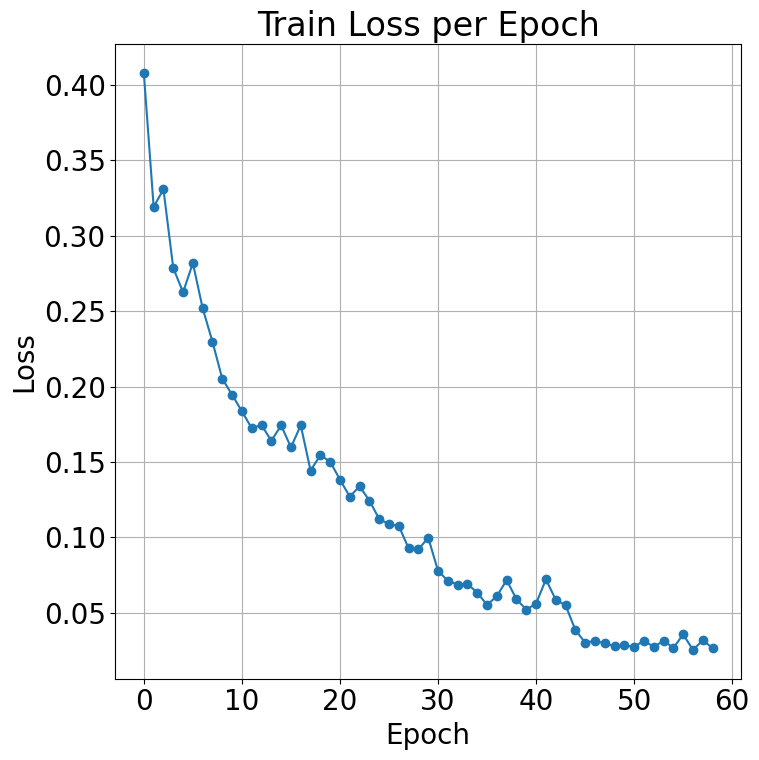

In [91]:
plt.plot(loss_history, marker='o')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")

✅ Precision: 0.9919
✅ Recall: 0.9899


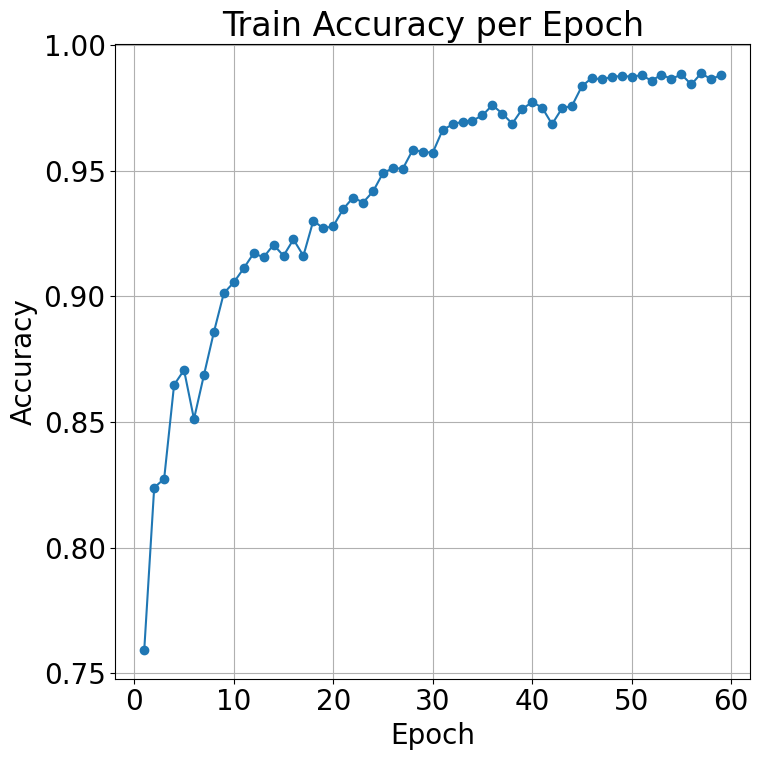

In [93]:
train_acc_list = [0.7593, 0.8239, 0.8274, 0.8648, 0.8707, 0.8512, 0.8687, 0.8858, 0.9013, 0.9056,
 0.9112, 0.9172, 0.9156, 0.9206, 0.9162, 0.9227, 0.9162, 0.9302, 0.9271, 0.9280,
 0.9348, 0.9394, 0.9374, 0.9418, 0.9491, 0.9511, 0.9509, 0.9584, 0.9576, 0.9572,
 0.9663, 0.9685, 0.9696, 0.9700, 0.9721, 0.9762, 0.9728, 0.9688, 0.9746, 0.9774,
 0.9752, 0.9686, 0.9749, 0.9759, 0.9837, 0.9870, 0.9864, 0.9874, 0.9878, 0.9875,
 0.9881, 0.9859, 0.9883, 0.9866, 0.9884, 0.9844, 0.9889, 0.9864, 0.9883]


plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, marker='o')
plt.title("Train Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()